In [20]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import operator

In [9]:
load_dotenv()

True

In [10]:
model = ChatOpenAI(model='gpt-4o-mini')

In [11]:
class EvaluationSchema(BaseModel) :
    feedback : str = Field(description='Detailed feedback for the essay')
    score :  int = Field(description = 'Score out of 10', ge=0, le=10)

In [12]:
Structured_model = model.with_structured_output(EvaluationSchema)

In [13]:
essay = '''
The AI Revolution: Redefining Humanity’s Future
“The real question is not whether intelligent machines can think, but whether humans can still think.”

— B. F. Skinner

Introduction

Human civilization has always advanced through technology—the wheel, steam engine, electricity, and the internet each marked milestones in our collective progress. Yet, the rise of Artificial Intelligence (AI) represents a turning point unlike any before. Unlike other tools, AI is capable of learning, reasoning, and creating—qualities once thought uniquely human. The AI revolution is not merely changing how we live; it is redefining what it means to be human.

From Human Intelligence to Artificial Intelligence

AI’s roots lie in humanity’s long quest to replicate the human mind. Alan Turing’s question—“Can machines think?”—sparked decades of exploration. Today, AI can compose music, diagnose diseases, predict weather, and even assist in governance.

From narrow AI, which performs specific tasks, we are now progressing towards general AI, capable of reasoning across multiple domains. This evolution marks a paradigm shift—AI is no longer just a tool but an entity that learns and evolves, sometimes beyond direct human supervision.

Economic Transformation: Growth and Displacement

AI is driving a new industrial revolution, enhancing productivity and efficiency across sectors—agriculture, health, finance, and education. Global estimates suggest it could add trillions to the world economy by 2030.

However, the benefits are uneven. Automation threatens jobs involving routine tasks while rewarding high-skill digital workers. This polarization risks deepening inequality, as data—the new oil—is increasingly concentrated in a few corporations. Without inclusive policies, AI may exacerbate rather than reduce global disparities.

Governance and Ethical Challenges

The AI revolution brings not only opportunities but profound ethical dilemmas. Who is accountable when an autonomous vehicle causes harm? How do we prevent algorithmic bias from reinforcing social prejudices?

AI systems often mirror the biases of their creators and datasets. In fields like recruitment or criminal justice, this can perpetuate discrimination. Moreover, the misuse of AI in surveillance, misinformation, and autonomous weaponry raises concerns for democracy and peace.

Thus, the need for ethical AI—transparent, accountable, and aligned with human values—is paramount. Global efforts such as the EU’s AI Act and UNESCO’s ethical guidelines reflect growing recognition of these concerns.

India and the Promise of “AI for All”

India stands at a crucial intersection of demographic potential and digital ambition. The government’s National Strategy for Artificial Intelligence envisions AI for Social Good.

Applications are already visible:

Agriculture: AI-driven weather prediction and crop monitoring help farmers.

Healthcare: Predictive diagnostics improve rural medical services.

Education: Personalized learning platforms bridge regional and linguistic divides.

However, challenges persist—limited digital infrastructure, skill deficits, and concerns over data privacy. India must ensure that AI remains a tool of inclusion, not exclusion.

The Human Dimension: Beyond Intelligence

Beyond economics and governance, AI challenges our conception of self. When machines can think and create, what remains distinctly human?

Our consciousness, empathy, and moral imagination cannot be replicated by algorithms. The task ahead is not to compete with machines but to complement them—blending artificial intelligence with emotional intelligence to create a more humane world.

Way Forward

Ethical Frameworks: Develop transparent, accountable, and bias-free AI systems.

Education and Reskilling: Integrate creativity and digital literacy in education.

Democratization: Prevent monopolization of data and AI access.

International Cooperation: Establish global norms for AI safety and governance.

Human-Centric Design: Ensure that AI serves human welfare and dignity.

Conclusion

The AI revolution is both a promise and a peril. It holds the potential to eradicate poverty and expand knowledge, yet it can also deepen inequality and erode privacy. The choice is not whether AI will shape our world—it already does—but whether humanity will guide this transformation wisely.

To truly benefit from this revolution, we must ensure that artificial intelligence serves human intelligence, not replaces it.
'''

In [ ]:
prompt = 'Evaluate the language quality of  the following essay and provide a feedback and assign a score out of 10'
Structured_model.invoke(prompt)

EvaluationSchema(feedback='The essay demonstrates a good command of language with varied vocabulary and sentence structures. However, there are several areas for improvement. Firstly, there are a few grammatical errors and awkward phrasing that can detract from the overall clarity of the writing. Secondly, some points are not fully developed, which makes certain arguments less persuasive. Additionally, transitions between paragraphs could be smoother to enhance the flow of ideas. Finally, the conclusion could be strengthened to more effectively summarize the key points discussed. Overall, the essay has a solid foundation but requires refinement in structure and clarity.', score=6)

In [36]:
class UPSCState(TypedDict) :
    essay : str
    language_feedback : str
    analysis_feedback : str
    clarity_feedback : str
    overall_feedback : str
    individuals_score : Annotated[list[int], operator.add]
    avg_score : float

In [37]:
def evaluate_language(state: UPSCState) :
    prompt = f"Evaluate the language quality of  the following essay and provide a feedback and assign a score out of 10. Here is the essay : {state["essay"]}"
    output = Structured_model.invoke(prompt)

    return {"language_feedback": output.feedback,
            "individuals_score":[output.score]
            }

In [38]:
def evaluate_analysis(state: UPSCState) :
    prompt = f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10. Here is the essay : {state["essay"]}"
    output = Structured_model.invoke(prompt)

    return {"analysis_feedback": output.feedback,
            "individuals_score":[output.score]
            }

In [39]:
def evaluate_thought(state: UPSCState) :
    prompt = f"Evaluate the clarity of thought of  the following essay and provide a feedback and assign a score out of 10. Here is the essay : {state["essay"]}"
    output = Structured_model.invoke(prompt)

    return {"clarity_feedback": output.feedback,
            "individuals_score":[output.score]
            }

In [40]:
def final_evaluate(state: UPSCState) :
    prompt = f"Evaluate this essay written by an upsc aspirant using the following feedback, create the summarized feedback \n language feedback - {state['language_feedback']} \n depth of analysis feedback - {state['analysis_feedback']} \n clarity of thought feedback - {state['clarity_feedback']}"
    overall_feedback = model.invoke(prompt).content

    # avg Score
    avg_score = sum(state['individuals_score'])/len(state['individuals_score'])

    return {"overall_feedback": overall_feedback,
            "avg_score": avg_score
            }

In [41]:
graph = StateGraph(UPSCState)

graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('evaluate_thought',evaluate_thought)
graph.add_node('final_evaluate',final_evaluate)


graph.add_edge(START,"evaluate_language" )
graph.add_edge(START,"evaluate_analysis" )
graph.add_edge(START,"evaluate_thought" )

graph.add_edge("evaluate_language",'final_evaluate' )
graph.add_edge("evaluate_thought",'final_evaluate' )
graph.add_edge("evaluate_analysis",'final_evaluate' )

graph.add_edge('final_evaluate', END)

workflow = graph.compile()

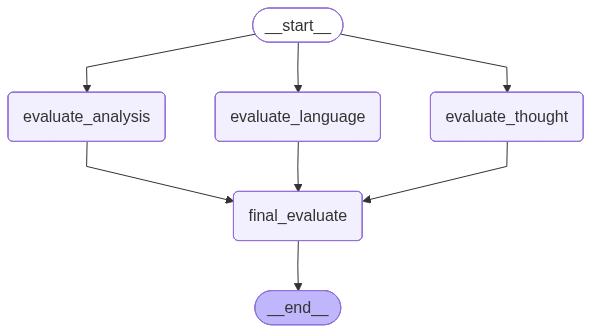

In [42]:
workflow

In [43]:
intial_state = {
    'essay' : essay
}

workflow.invoke(intial_state)

{'essay': '\nThe AI Revolution: Redefining Humanity’s Future\n“The real question is not whether intelligent machines can think, but whether humans can still think.”\n\n— B. F. Skinner\n\nIntroduction\n\nHuman civilization has always advanced through technology—the wheel, steam engine, electricity, and the internet each marked milestones in our collective progress. Yet, the rise of Artificial Intelligence (AI) represents a turning point unlike any before. Unlike other tools, AI is capable of learning, reasoning, and creating—qualities once thought uniquely human. The AI revolution is not merely changing how we live; it is redefining what it means to be human.\n\nFrom Human Intelligence to Artificial Intelligence\n\nAI’s roots lie in humanity’s long quest to replicate the human mind. Alan Turing’s question—“Can machines think?”—sparked decades of exploration. Today, AI can compose music, diagnose diseases, predict weather, and even assist in governance.\n\nFrom narrow AI, which performs 